# Importing Packages

In [3]:
# General Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# Perceptron
from sklearn.linear_model import Perceptron # This module (perceptron) has a bunch of hyperparameters 

# # Neural Networks
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Metrics
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import mean_squared_error


# EDA and Pre-processing

In [4]:
df_og = pd.read_csv("/Users/hamzaalshamy/Desktop/NYU/2024/Spring 2024/FML/Homeworks/Homework 3/diabetes.csv")
data = df_og.to_numpy()
df_og.head()

,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,Myocardial,PhysActivity,Fruit,Vegetables,...,NotAbleToAffordDoctor,GeneralHealth,MentalHealth,PhysicalHealth,HardToClimbStairs,BiologicalSex,AgeBracket,EducationBracket,IncomeBracket,Zodiac
0,0,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,1,9,4,3,10
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,1,7,6,1,11
2,0,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,1,9,4,8,2
3,0,1,0,27,0,0,0,1,1,1,...,0,2,0,0,0,1,11,3,6,11
4,0,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,1,11,5,4,8


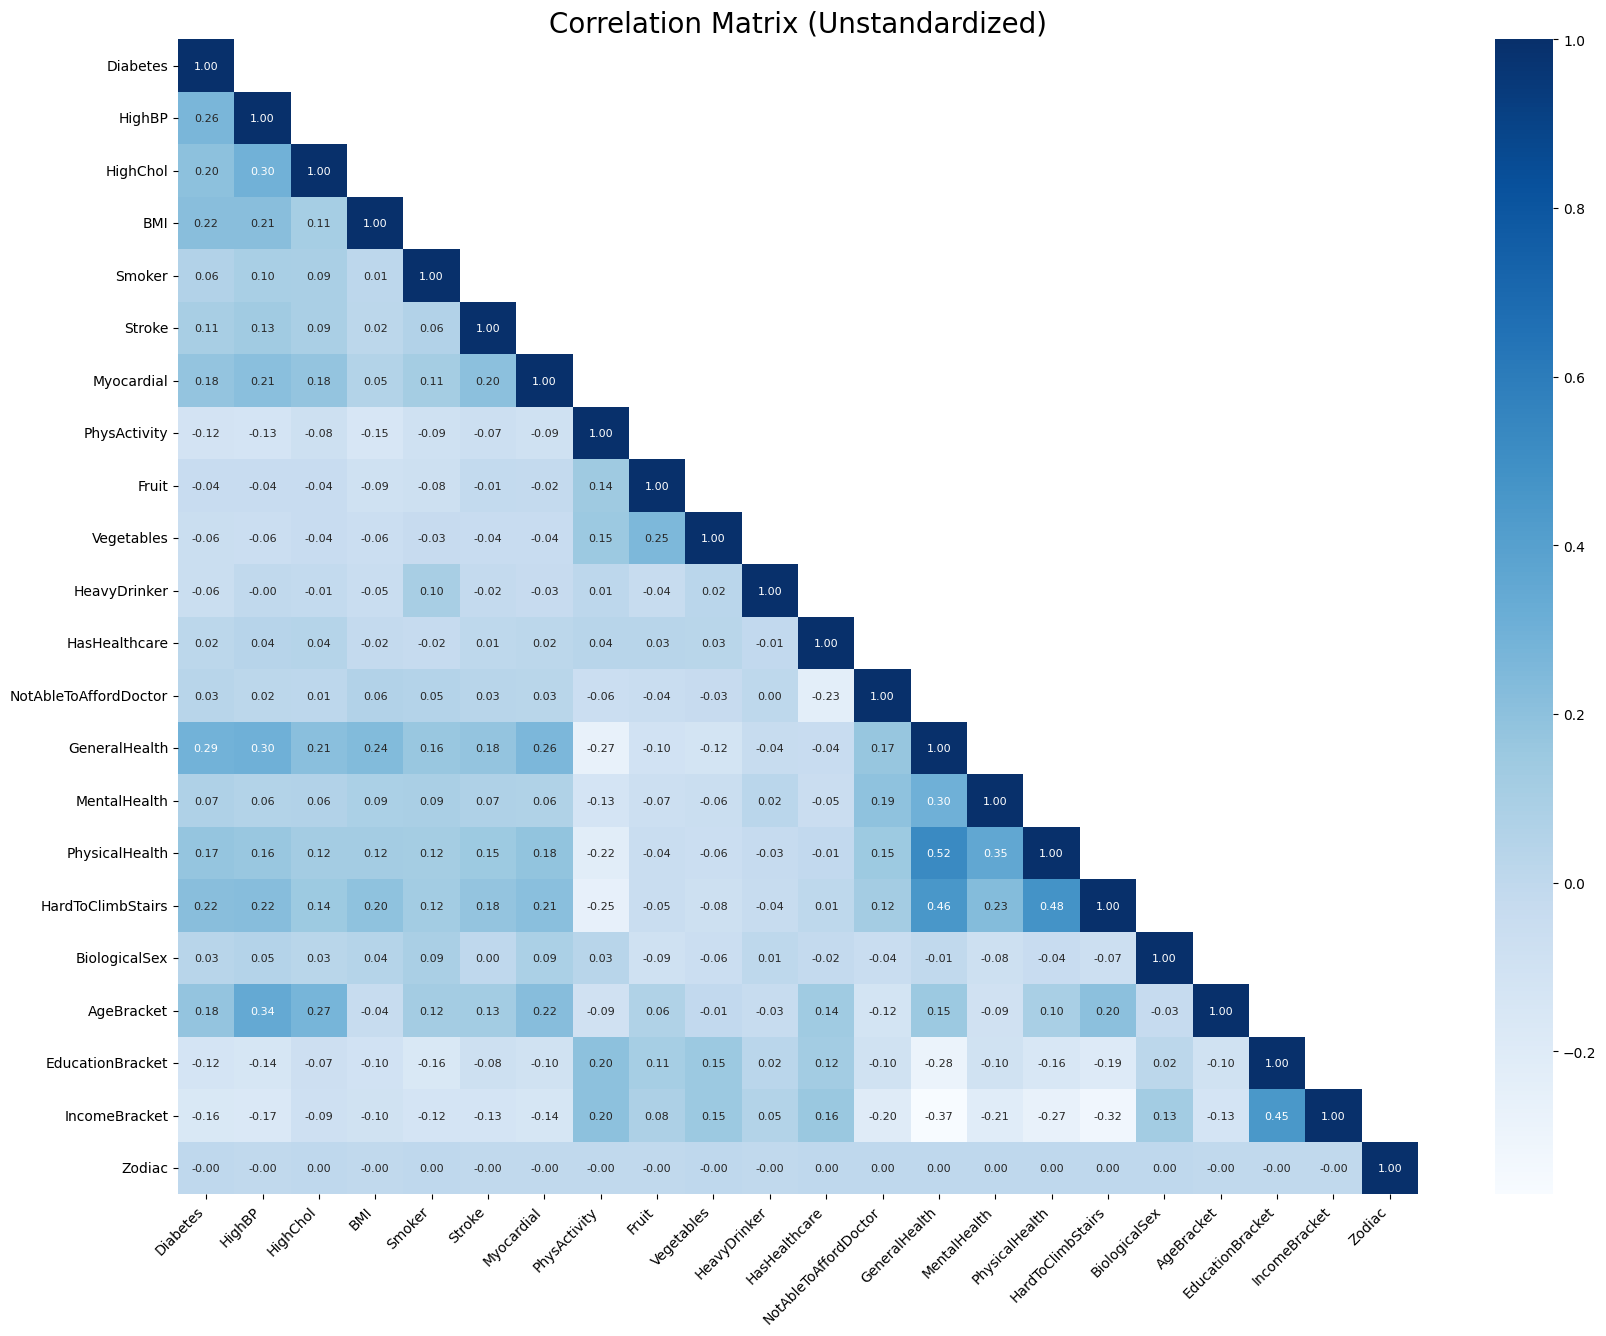

In [5]:
correlation_matrix = pd.DataFrame(df_og).corr()

# Generate a mask for the upper triangle without the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Increase the figure size
plt.figure(figsize=(20, 15))

# Create the heatmap with the mask, keeping the diagonal visible
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cbar=True, cmap="Blues", annot_kws={'size': 8}, mask=mask)

# Title
plt.title('Correlation Matrix (Unstandardized)', fontsize=20)

# Rotate x-axis tick labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=10)

# Rotate y-axis tick labels for better readability
plt.yticks(fontsize=10)

# Show plot
plt.show()

# Perceptron

In [6]:
# Separate features and target
X = df_og.iloc[:, 1:].values  # All columns except the first one (features)
y = df_og.iloc[:, 0].values  # Only the first column (target: diabetes status)

# Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)

# Initialize and train the Perceptron model with explicit shuffle
perceptron_model = Perceptron(max_iter=1000, tol=1e-3, random_state=42, shuffle=True, class_weight= "balanced")
perceptron_model.fit(X_train, y_train)

# Model evaluation using AUC
y_scores = perceptron_model.decision_function(X_test)
auc_score_decision_function = roc_auc_score(y_test, y_scores)
print(f"AUC Score using decision function: {round(auc_score_decision_function,3)}")

# Generate binary predictions for MCC calculation
y_pred = perceptron_model.predict(X_test)

# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {round(mcc, 3)}\n")

# Model evaluation using accuracy
accuracy_test = perceptron_model.score(X_test, y_test)
print(f"Accuracy on test set: {round(accuracy_test, 3)}")

# Calculate and print accuracy on the training set
accuracy_training = perceptron_model.score(X_train, y_train)
print(f"Accuracy on training set: {round(accuracy_training, 3)}")


AUC Score using decision function: 0.648
Matthews Correlation Coefficient: 0.16

Accuracy on test set: 0.609
Accuracy on training set: 0.61


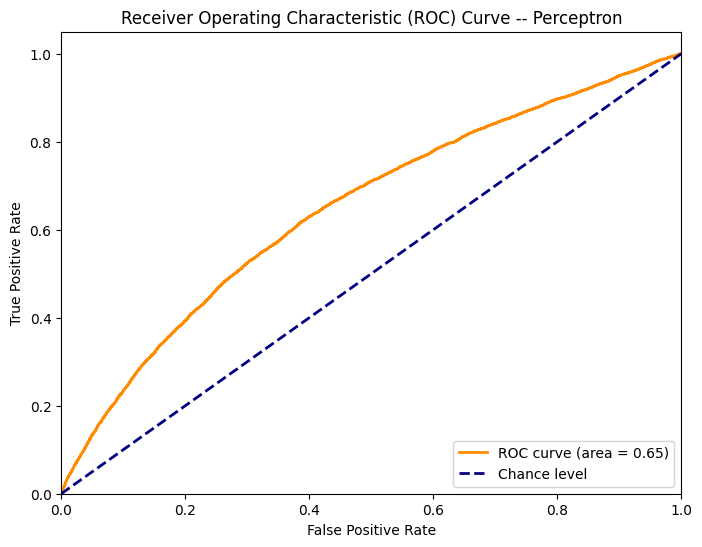

In [7]:
# Compute ROC curve values: FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score_decision_function:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance level')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve -- Perceptron')
plt.legend(loc="lower right")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.61      0.73     43739
           1       0.20      0.62      0.31      6997

    accuracy                           0.61     50736
   macro avg       0.56      0.61      0.52     50736
weighted avg       0.81      0.61      0.67     50736



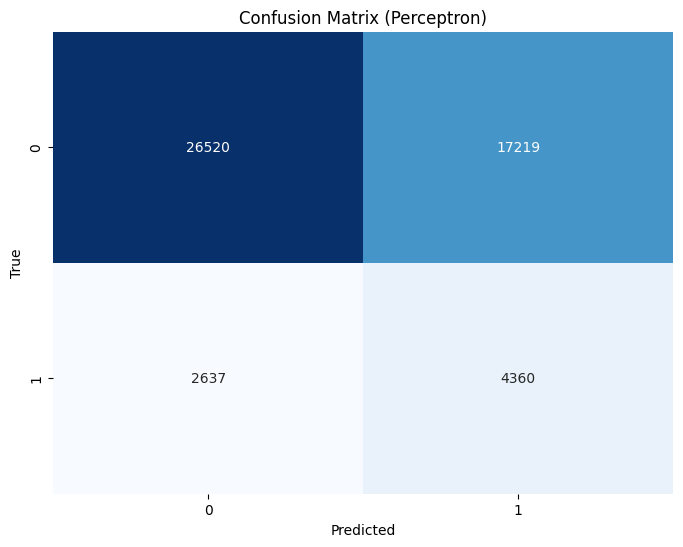

In [8]:
# Generate binary predictions
y_pred = perceptron_model.predict(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualization of Confusion Matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Perceptron)')
plt.show()

# Feedforward Neural Network (Diabetes Classification)

In [9]:
# Defining the models

def create_model(n_hidden_layers, activation, input_size):
    layers = [nn.Linear(input_size, 10)]
    for _ in range(n_hidden_layers):
        if activation == 'relu':
            layers.append(nn.ReLU())
        elif activation == 'sigmoid':
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(10, 10))
    layers.append(nn.Linear(10, 1))
    return nn.Sequential(*layers)

def train_model(model, X_train, y_train, X_test, y_test, epochs=100):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    X_train, y_train = torch.FloatTensor(X_train), torch.FloatTensor(y_train)
    X_test, y_test = torch.FloatTensor(X_test), torch.FloatTensor(y_test)

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()
    
    # Evaluate the model
    with torch.no_grad():
        y_pred_train = torch.sigmoid(model(X_train)).squeeze()
        y_pred_test = torch.sigmoid(model(X_test)).squeeze()
    
    # Convert predictions to binary
    y_pred_train_bin = (y_pred_train > 0.5).numpy()
    y_pred_test_bin = (y_pred_test > 0.5).numpy()
    
    # Calculate metrics
    auc = roc_auc_score(y_test.numpy(), y_pred_test.numpy())
    mcc = matthews_corrcoef(y_test.numpy(), y_pred_test_bin)
    acc_train = accuracy_score(y_train.numpy(), y_pred_train_bin)
    acc_test = accuracy_score(y_test.numpy(), y_pred_test_bin)
    
    return auc, mcc, acc_train, acc_test

In [10]:
activations = ['relu', 'sigmoid', None]
n_hidden_layers_options = [1, 2, 3, 4, 5]  # Up to 5 hidden layers
results = []

results = []
for activation in activations:
    for n_hidden_layers in n_hidden_layers_options:
        model = create_model(n_hidden_layers, activation, X_train.shape[1])
        auc, mcc, acc_train, acc_test = train_model(model, X_train, y_train, X_test, y_test)
        results.append({
            'Activation Function': activation if activation else 'None',
            'Number of Hidden Layers': n_hidden_layers,
            'AUC': auc,
            'MCC': mcc,
            'Training Accuracy': acc_train,
            'Testing Accuracy': acc_test
        })


In [12]:
# Converting the results list, which is now a list of dictionaries, to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
results_df

,Activation Function,Number of Hidden Layers,AUC,MCC,Training Accuracy,Testing Accuracy
0,relu,1,0.613885,0.008253,0.860045,0.861716
1,relu,2,0.552205,0.000000,0.860311,0.862090
2,relu,3,0.296718,0.000000,0.860311,0.862090
3,relu,4,0.497921,0.000000,0.860311,0.862090
4,relu,5,0.411430,0.000000,0.860311,0.862090
5,sigmoid,1,0.502795,0.000000,0.860311,0.862090
6,sigmoid,2,0.467190,0.000000,0.860311,0.862090
7,sigmoid,3,0.392342,0.000000,0.860311,0.862090
8,sigmoid,4,0.611460,0.000000,0.860311,0.862090
9,sigmoid,5,0.410079,0.000000,0.860311,0.862090


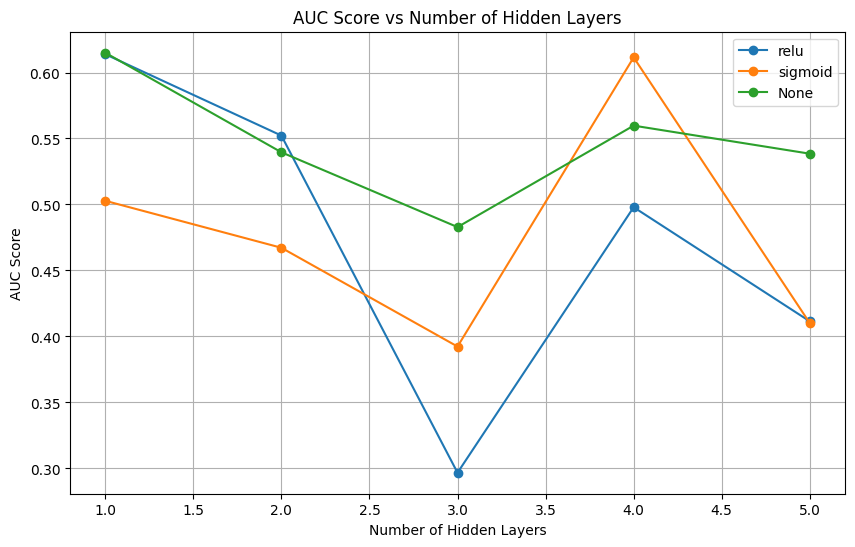

In [13]:
# Plotting AUC Scores by Number of Hidden Layers for each Activation Function
plt.figure(figsize=(10, 6))
for activation in activations:
    # Filter and plot each activation's results
    filtered_df = results_df[results_df['Activation Function'] == (activation if activation else 'None')]
    plt.plot(filtered_df['Number of Hidden Layers'], filtered_df['AUC'], label=activation if activation else "None", marker='o')

plt.xlabel('Number of Hidden Layers')
plt.ylabel('AUC Score')
plt.title('AUC Score vs Number of Hidden Layers')
plt.legend()
plt.grid(True)
plt.show()

# Deep Netwrok (Three hidden layers)

In [14]:
class DiabetesClassifier(nn.Module):
    def __init__(self, input_dim):
        super(DiabetesClassifier, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)     # Hidden Layer 1
        self.layer2 = nn.Linear(128, 64)            # Hidden Layer 2
        self.layer3 = nn.Linear(64, 32)             # Hidden Layer 3
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.output_layer(x)
        return x

# Prepare the data
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

# Initialize model, loss, and optimizer
model = DiabetesClassifier(X_train.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):  # Adjust the number of epochs according to the dataset and needs
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_train = torch.sigmoid(model(X_train_tensor)).squeeze()
    y_pred_test = torch.sigmoid(model(X_test_tensor)).squeeze()

# Convert predictions to binary
y_pred_test_bin = (y_pred_test > 0.5).numpy()
y_train_pred_bin = (y_pred_train > 0.5).numpy()

# Calculate metrics
auc = roc_auc_score(y_test, y_pred_test.numpy())
accuracy_test = accuracy_score(y_test, y_pred_test_bin)
mcc = matthews_corrcoef(y_test, y_pred_test_bin)

accuracy_train = accuracy_score(y_train, y_train_pred_bin)


In [15]:
# Print metrics
print(f"AUC Score: {auc:.3f}")
print(f"Matthews Correlation Coefficient: {mcc:.3f}\n")

print(f"Test Accuracy: {accuracy_test:.3f}")
print(f"Training Accuracy: {accuracy_train:.3f}")

AUC Score: 0.827
Matthews Correlation Coefficient: 0.000

Test Accuracy: 0.862
Training Accuracy: 0.860


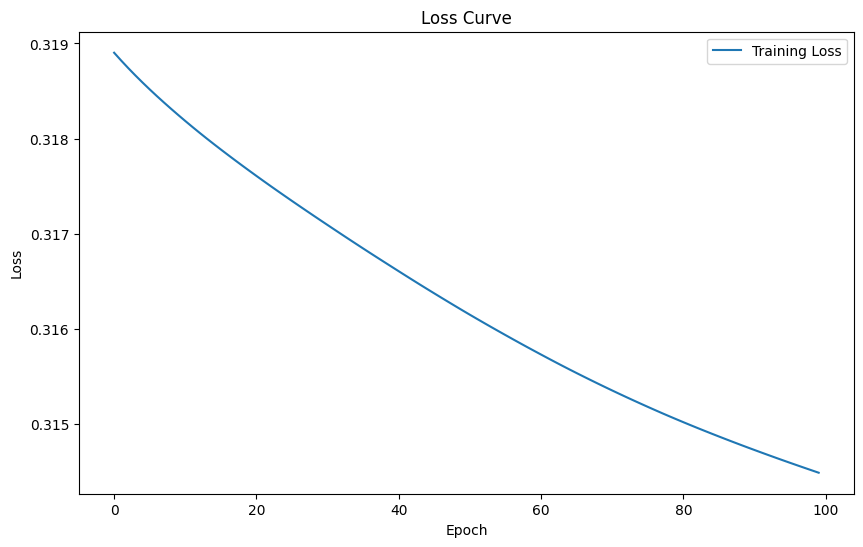

In [16]:
# Adjust the training loop to store loss values
losses = []
for epoch in range(100):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


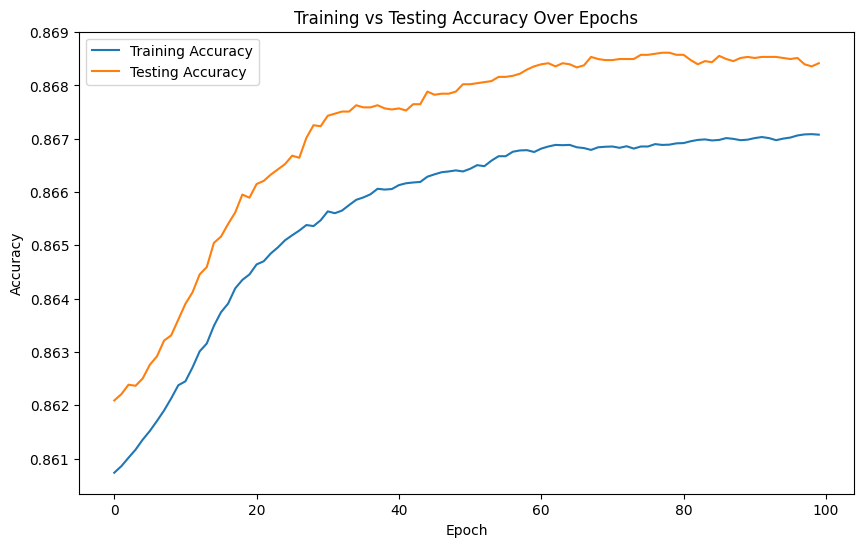

In [17]:
# Modify the training loop to calculate accuracy at each epoch
train_accuracies = []
test_accuracies = []

for epoch in range(100):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred_train = torch.sigmoid(model(X_train_tensor)).squeeze()
        y_pred_test = torch.sigmoid(model(X_test_tensor)).squeeze()
        train_accuracy = accuracy_score(y_train, (y_pred_train > 0.5).numpy())
        test_accuracy = accuracy_score(y_test, (y_pred_test > 0.5).numpy())
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plotting accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.title('Training vs Testing Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93     43739
           1       0.00      0.00      0.00      6997

    accuracy                           0.86     50736
   macro avg       0.43      0.50      0.46     50736
weighted avg       0.74      0.86      0.80     50736



/opt/anaconda3/envs/fml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/fml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/fml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


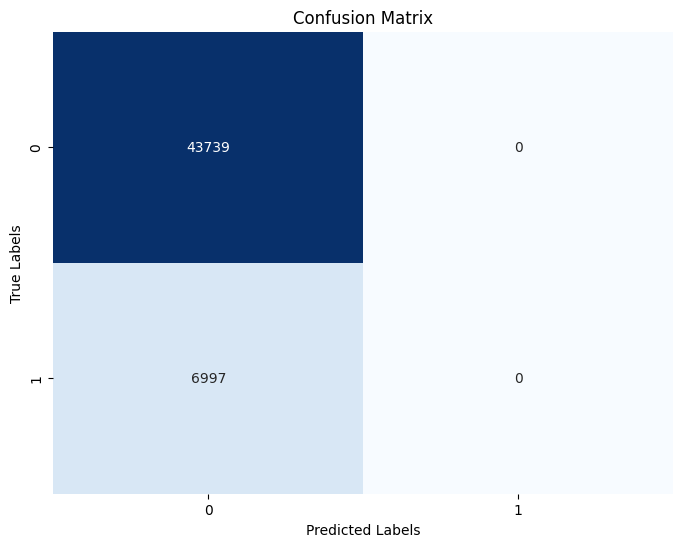

In [18]:
print("Classification Report:")
report = classification_report(y_test, y_pred_test_bin)
print(report)

cm = confusion_matrix(y_test, y_pred_test_bin)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


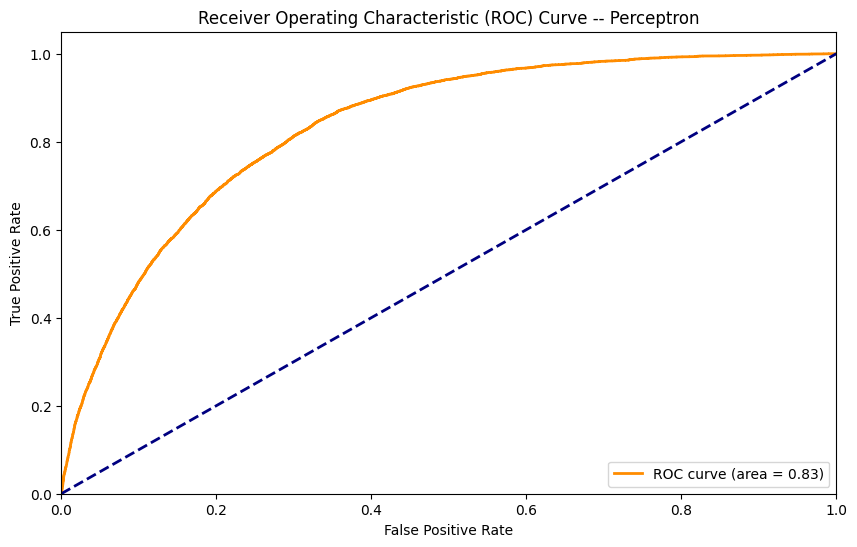

In [19]:
from sklearn.metrics import roc_curve, auc  # Re-import to ensure auc is not overwritten

# Generating ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test.numpy())
roc_auc = auc(fpr, tpr)  # Ensuring auc is used as a function

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve -- Perceptron')
plt.legend(loc="lower right")
plt.show()

# Feedforward Neural Network (BMI Prediction)

In [20]:
# Creating new input features and outcome from the original dataframe
X2 = df_og.drop(columns=['BMI'])
y2 = df_og['BMI'].values

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Standardizing the outcome ----- OPTIONAL
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


# Converting to PyTorch tensors
X_train_tensor2 = torch.FloatTensor(X_train)
# y_train_tensor2 = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor2 = torch.FloatTensor(X_test)
# y_test_tensor2 = torch.FloatTensor(y_test).view(-1, 1)

# Convert to PyTorch tensors
y_train_tensor2 = torch.FloatTensor(y_train_scaled).view(-1, 1)
y_test_tensor2 = torch.FloatTensor(y_test_scaled).view(-1, 1)

In [21]:
# Defining

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn=None):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.fc1(x)
        if self.activation_fn is not None:
            x = self.activation_fn(x)
        x = self.fc2(x)
        return x

def create_model(input_size, activation='relu'):
    hidden_size = 128
    output_size = 1
    if activation == 'relu':
        activation_fn = nn.ReLU()
    elif activation == 'sigmoid':
        activation_fn = nn.Sigmoid()
    else:
        activation_fn = None
    return SimpleNN(input_size, hidden_size, output_size, activation_fn)


# Training Function
def train_and_evaluate(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=100):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        rmse = torch.sqrt(criterion(predictions, y_test_tensor)).item()
    return rmse

In [22]:
activations = ['relu', 'sigmoid', 'none']
results = []

input_size = X_train.shape[1]
for activation in activations:
    model = create_model(input_size, activation)
    rmse = train_and_evaluate(model, X_train_tensor2, y_train_tensor2, X_test_tensor2, y_test_tensor2)
    results.append({'Activation': activation, 'RMSE': rmse})

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)


In [23]:
results_df


,Activation,RMSE
0,relu,0.904606
1,sigmoid,0.924143
2,none,0.926045


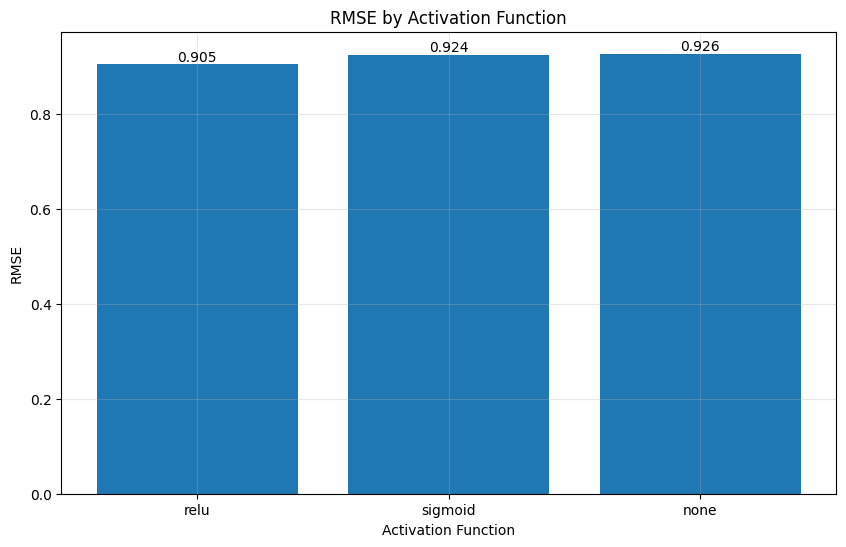

In [24]:
# Plotting RMSE for different activation functions
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['Activation'], results_df['RMSE'])
plt.xlabel('Activation Function')
plt.ylabel('RMSE')
plt.title('RMSE by Activation Function')
plt.grid(alpha=0.3)

# Adding the text on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.show()

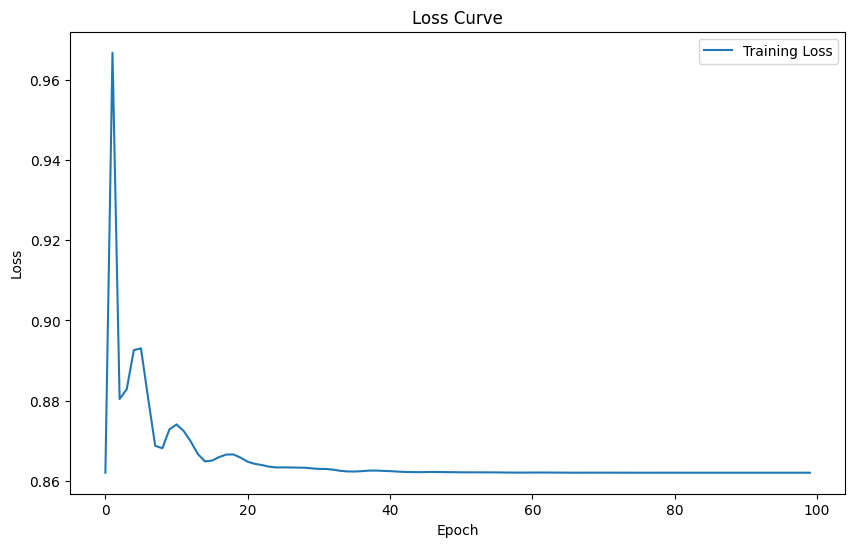

In [25]:
def train_and_evaluate(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=100):
    criterion = nn.MSELoss()  # Loss function for regression
    optimizer = optim.Adam(model.parameters(), lr=0.01)  # Optimizer
    losses = []  # List to store loss per epoch for tracking

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        optimizer.zero_grad()  # Clear gradients
        outputs = model(X_train_tensor)  # Get model outputs
        loss = criterion(outputs, y_train_tensor)  # Compute loss
        losses.append(loss.item())  # Save the loss for this epoch
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

    # After training, evaluate the model on the test data
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        predictions = model(X_test_tensor)  # Get predictions
        rmse = torch.sqrt(criterion(predictions, y_test_tensor)).item()  # Calculate RMSE

    return losses, rmse, predictions

# Assuming model training includes capturing losses
# Call train_and_evaluate and unpack returned values correctly
losses, rmse, predictions = train_and_evaluate(model, X_train_tensor2, y_train_tensor2, X_test_tensor2, y_test_tensor2)

# Now, plot the training losses
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()


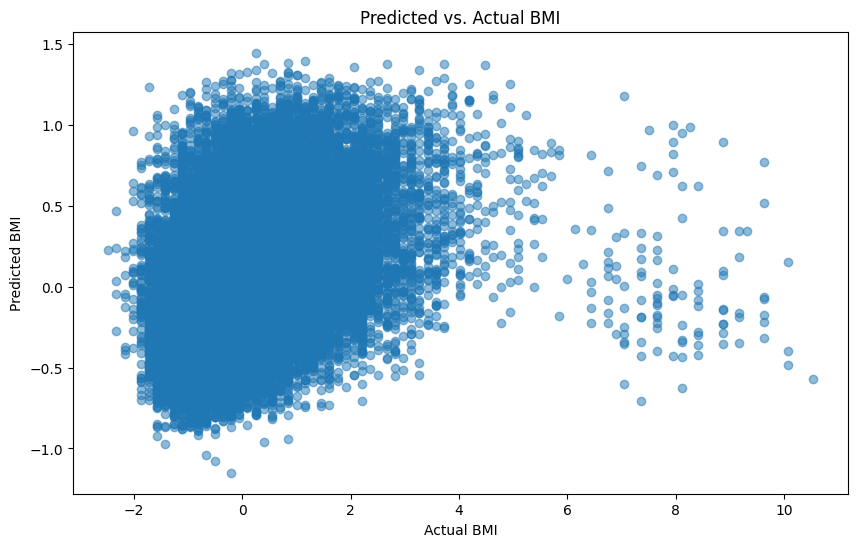

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tensor2.numpy(), predictions.numpy(), alpha=0.5)
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('Predicted vs. Actual BMI')
# plt.plot([y_test_tensor2.min(), y_test_tensor2.max()], [y_test_tensor2.min(), y_test_tensor2.max()], 'k--', lw=4)
plt.show()


# Neural Network (BMI Prediction)

In [27]:
class DynamicNN(nn.Module):
    def __init__(self, input_size, num_layers, activation_fn):
        """
        Initialize the DynamicNN class with specified number of hidden layers and activation function.

        Args:
            input_size (int): The number of input features.
            num_layers (int): The number of hidden layers in the network.
            activation_fn (torch.nn.modules.activation): The activation function to apply after each hidden layer.
        """
        super(DynamicNN, self).__init__()
        # Creating a list of hidden layers dynamically.
        # The first layer takes the input size, and each subsequent layer takes the output of the previous layer (128 units here).
        self.layers = nn.ModuleList([nn.Linear(input_size if i == 0 else 128, 128) for i in range(num_layers)])
        # Final output layer that maps from the last hidden layer to the output feature (1 unit in this case).
        self.final = nn.Linear(128, 1)
        self.activation_fn = activation_fn

    def forward(self, x):
        """
        Defines the computation performed at every call of the model.

        Args:
            x (Tensor): The input data.

        Returns:
            Tensor: The output of the network after passing through the hidden layers and the output layer.
        """
        # Iterate through each layer and apply the activation function if it is not None.
        for layer in self.layers:
            x = layer(x)
            if self.activation_fn:
                x = self.activation_fn(x)
        # The final layer output, which is typically used for regression tasks.
        x = self.final(x)
        return x

def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=20):
    """
    Trains and evaluates the neural network model.

    Args:
        model (DynamicNN): The neural network model to train.
        X_train (Tensor): Training data features.
        y_train (Tensor): Training data targets.
        X_test (Tensor): Test data features.
        y_test (Tensor): Test data targets.
        epochs (int): Number of epochs to train the model.

    Returns:
        float: The root mean square error of the model on the test dataset.
    """
    # Loss function for regression (Mean Squared Error).
    criterion = nn.MSELoss()
    # Optimizer for updating weights (Adam in this case).
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Training loop over the specified number of epochs.
    for epoch in range(epochs):
        model.train()  # Set the model to training mode (important for things like dropout and batchnorm).
        optimizer.zero_grad()  # Clear gradients before each backward pass.
        outputs = model(X_train)  # Forward pass.
        loss = criterion(outputs, y_train)  # Calculate loss.
        loss.backward()  # Compute gradients.
        optimizer.step()  # Update model parameters.

    # Evaluate the model on test data after training.
    model.eval()  # Set the model to evaluation mode.
    with torch.no_grad():  # Turn off gradients to save memory and computations.
        predictions = model(X_test)
        rmse = torch.sqrt(criterion(predictions, y_test)).item()  # Calculate RMSE.

    return rmse

In [28]:
# Configuration options for activations
activations = {'none': None, 'sigmoid': nn.Sigmoid(), 'relu': nn.ReLU(), 'softplus': nn.Softplus()}
results_q5 = []

# Run experiments
for activation_name, activation_fn in activations.items():
    for num_layers in range(1, 9):  # 1 to 8 hidden layers
        model = DynamicNN(X_train_tensor2.shape[1], num_layers, activation_fn)
        rmse = train_and_evaluate(model, X_train_tensor2, y_train_tensor2, X_test_tensor2, y_test_tensor2)
        results_q5.append({
            'Activation': activation_name,
            'Hidden Layers': num_layers,
            'RMSE': rmse
        })
        print(f'Activation: {activation_name}, Layers: {num_layers}, RMSE: {rmse}')

# Convert results to DataFrame for better visualization and analysis
results_df_q5 = pd.DataFrame(results_q5)

Activation: none, Layers: 1, RMSE: 0.9278658628463745
Activation: none, Layers: 2, RMSE: 0.9311821460723877
Activation: none, Layers: 3, RMSE: 0.9302237629890442
Activation: none, Layers: 4, RMSE: 0.9359303712844849
Activation: none, Layers: 5, RMSE: 0.985883891582489
Activation: none, Layers: 6, RMSE: 0.9561177492141724
Activation: none, Layers: 7, RMSE: 1.1210947036743164
Activation: none, Layers: 8, RMSE: 1.0354335308074951
Activation: sigmoid, Layers: 1, RMSE: 0.9289306402206421
Activation: sigmoid, Layers: 2, RMSE: 0.9553827047348022
Activation: sigmoid, Layers: 3, RMSE: 0.9957577586174011
Activation: sigmoid, Layers: 4, RMSE: 0.9952518939971924
Activation: sigmoid, Layers: 5, RMSE: 1.0382736921310425
Activation: sigmoid, Layers: 6, RMSE: 1.0248260498046875
Activation: sigmoid, Layers: 7, RMSE: 1.0323268175125122
Activation: sigmoid, Layers: 8, RMSE: 1.0288945436477661
Activation: relu, Layers: 1, RMSE: 0.9127277135848999
Activation: relu, Layers: 2, RMSE: 0.9176152348518372
Activ

In [29]:
results_df_q5

,Activation,Hidden Layers,RMSE
0,none,1,0.927866
1,none,2,0.931182
2,none,3,0.930224
3,none,4,0.935930
4,none,5,0.985884
5,none,6,0.956118
6,none,7,1.121095
7,none,8,1.035434
8,sigmoid,1,0.928931
9,sigmoid,2,0.955383


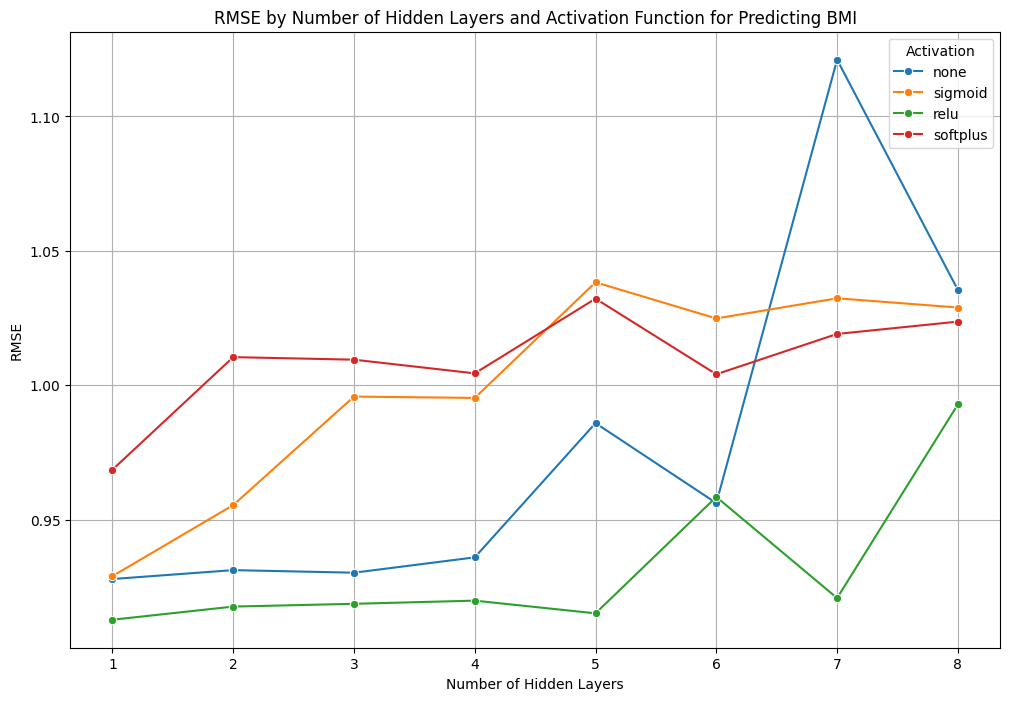

In [30]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df_q5, x='Hidden Layers', y='RMSE', hue='Activation', marker='o')
plt.title('RMSE by Number of Hidden Layers and Activation Function for Predicting BMI')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

# Further Exploration

## Feature Importance

In [31]:
X = df_og.iloc[:, 1:].values  # All columns except the first one (features)
y = df_og.iloc[:, 0].values  # Only the first column (target: diabetes status)

# Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)

# Dictionary to hold AUC scores when each feature is dropped
auc_scores = {}

# Loop through each feature index
for idx in range(X_train.shape[1]):
    # Use numpy to delete the column from X_train and X_test
    X_train_dropped = np.delete(X_train, idx, axis=1)
    X_test_dropped = np.delete(X_test, idx, axis=1)
    
    # Initialize and train the Perceptron model
    perceptron_model = Perceptron(max_iter=1000, tol=1e-3, random_state=42, shuffle=True, class_weight="balanced")
    perceptron_model.fit(X_train_dropped, y_train)
    
    # Get the decision function scores
    y_scores_dropped = perceptron_model.decision_function(X_test_dropped)
    
    # Calculate the AUC
    auc_score_dropped = roc_auc_score(y_test, y_scores_dropped)
    
    # Store the AUC score in the dictionary using the column index as key
    auc_scores[df_og.columns[idx + 1]] = auc_score_dropped  # +1 to account for target column at index 0


In [32]:
# Find the feature whose removal least affects the AUC
least_important_feature = max(auc_scores, key=auc_scores.get)
smallest_impact = auc_scores[least_important_feature]

# Convert the AUC scores dictionary to a DataFrame
auc_scores_df = pd.DataFrame(list(auc_scores.items()), columns=['Feature', 'AUC'])

# Sort the DataFrame by AUC scores in descending order for better visualization
auc_scores_df_sorted = auc_scores_df.sort_values(by='AUC', ascending=False)

In [33]:
auc_scores_df_sorted.sort_values(by="AUC", ascending= True)

,Feature,AUC
14,PhysicalHealth,0.622147
0,HighBP,0.657943
12,GeneralHealth,0.690835
19,IncomeBracket,0.709569
13,MentalHealth,0.712183
8,Vegetables,0.712851
20,Zodiac,0.720770
2,BMI,0.721243
1,HighChol,0.723139
9,HeavyDrinker,0.725514


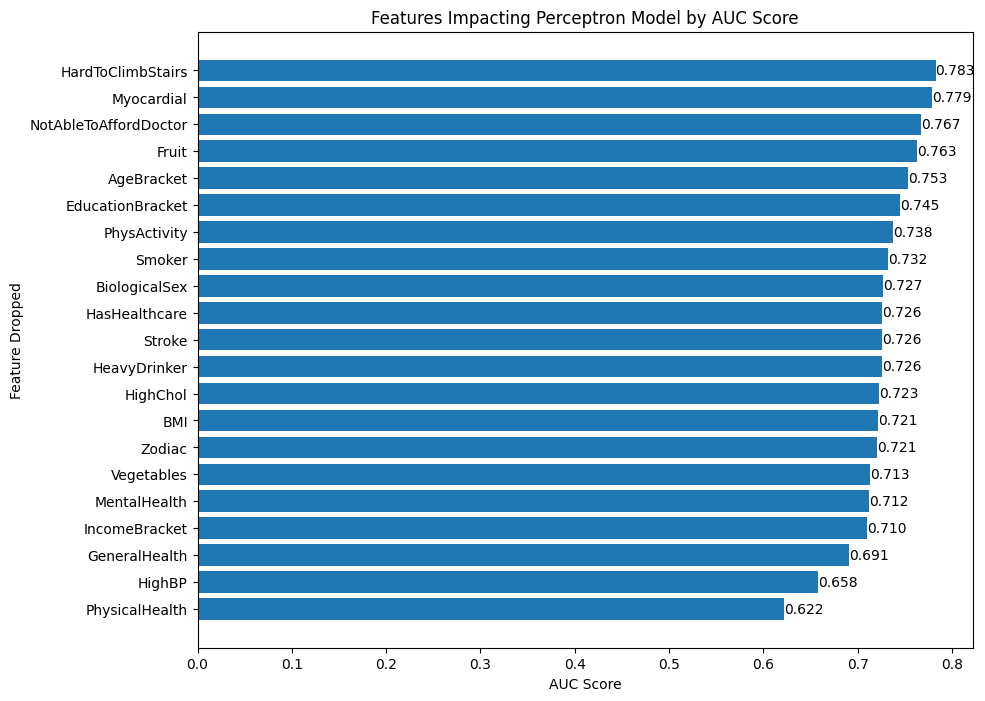

In [34]:
# Plotting
plt.figure(figsize=(10, 8))
bars = plt.barh(auc_scores_df_sorted['Feature'], auc_scores_df_sorted['AUC'])
plt.xlabel('AUC Score')
plt.ylabel('Feature Dropped')
plt.title('Features Impacting Perceptron Model by AUC Score')
plt.gca().invert_yaxis()  # Invert y axis for better readability

# Add text annotations to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.3f}',
             va='center', ha='left')

plt.show()